# Query Sentinel-2 images

In this notebook we will show how to query Sentinel-2 images over an area between two given dates. We will use the `sentinelsat` package to obtain the Sentinel-2 product names and we will read those from the [public GCP bucket](https://cloud.google.com/storage/docs/public-datasets/sentinel-2) (`gs://gcp-public-data-sentinel-2/tiles`).

Set the env variables to be able to read from the Google bucket. This  will incur in reading costs.

In [1]:
import os
import datetime
from shapely.geometry import box
import geopandas as gpd

# Donwload key from next line link to access the buckets and requester pays requests to public bucket (this is needed to query Sentinel-2 data)
# https://console.cloud.google.com/iam-admin/serviceaccounts/details/113408056464434182094/keys?authuser=1&project=cs-starcop-dtacs&supportedpurview=project
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/gonzalo/Downloads/cs-starcop-dtacs-requester-pays.json"
os.environ["GS_USER_PROJECT"] = "cs-starcop-dtacs"

In [2]:
import geopandas as gpd

# aoi = gpd.read_file("/home/gonzalo/Downloads/sagunt_small.geojson")
aoi = gpd.read_file("/home/gonzalo/Downloads/liria.geojson")
aoi.explore()

### Step 1: Select dates and area of interest to read

In [3]:
polygon_read = aoi.iloc[0].geometry
crs_polygon = aoi.crs

datetime_str = "2019-09-28"
date_of_interest = datetime.datetime.strptime(datetime_str, "%Y-%m-%d")

date_start_search = date_of_interest - datetime.timedelta(days=1)
date_end_search = date_of_interest + datetime.timedelta(days=1)

print(f"Querying images between {date_start_search} and {date_end_search}\nArea: {polygon_read}")

Querying images between 2019-09-27 00:00:00 and 2019-09-29 00:00:00
Area: POLYGON ((-0.74432373046875 39.52099229357195, -0.383148193359375 39.52099229357195, -0.383148193359375 39.81486542536203, -0.74432373046875 39.81486542536203, -0.74432373046875 39.52099229357195))


### Step 2: Query the products

In [4]:
from sentinelsat.sentinel import SentinelAPI
# 'https://scihub.copernicus.eu/apihub'
api = SentinelAPI('gonzmg88', "Gdz44cWAZzfxtNC", api_url='https://scihub.copernicus.eu/dhus/')

/home/gonzalo/miniconda3/envs/starcop/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%%time
from georeader.readers import S2_SAFE_reader
from datetime import timedelta


# Query the S2 images available in that period
products = api.query(area=str(polygon_read),
                     date=(date_start_search, date_end_search),
                     platformname='Sentinel-2',
                     producttype='S2MSI1C',
                     cloudcoverpercentage=(0, 80))
products_gpd = api.to_geodataframe(products)

# Set the tile name
products_gpd["mgrs_tile"] = products_gpd.title.apply(lambda x: S2_SAFE_reader.s2_name_split(x)[5])

longitude = polygon_read.centroid.coords[0][0]
hours_add = longitude * 12/180.

products_gpd["solartime"] = products_gpd["datatakesensingstart"].apply(lambda x: x+timedelta(hours=hours_add))
products_gpd["solarday"] = products_gpd["solartime"].apply(lambda x: x.strftime("%Y-%m-%d"))

# Compute the overlap of the product with the AoI polygon

products_gpd["overlappercentage"] = products_gpd.geometry.apply(lambda x: x.intersection(polygon_read).area / polygon_read.area * 100)
products_gpd[["title", "mgrs_tile", "overlappercentage","cloudcoverpercentage", "solarday", "datatakesensingstart","solartime", "geometry"]].reset_index(drop=True)

CPU times: user 697 ms, sys: 41.9 ms, total: 739 ms
Wall time: 2.41 s


,title,mgrs_tile,overlappercentage,cloudcoverpercentage,solarday,datatakesensingstart,solartime,geometry
0,S2B_MSIL1C_20190928T105029_N0208_R051_T31SBD_2...,31SBD,18.692485,8.7955,2019-09-28,2019-09-28 10:50:29.024,2019-09-28 10:48:13.727369,"MULTIPOLYGON (((-0.45026 38.70992, 0.00000 38...."
1,S2B_MSIL1C_20190928T105029_N0208_R051_T31TBE_2...,31TBE,22.484020,13.5730,2019-09-28,2019-09-28 10:50:29.024,2019-09-28 10:48:13.727369,"MULTIPOLYGON (((-0.49451 39.60901, 0.00000 39...."
2,S2B_MSIL1C_20190928T105029_N0208_R051_T30SYJ_2...,30SYJ,54.697682,10.2055,2019-09-28,2019-09-28 10:50:29.024,2019-09-28 10:48:13.727369,"MULTIPOLYGON (((0.56207 38.70656, 0.61236 39.6..."
3,S2B_MSIL1C_20190928T105029_N0208_R051_T30TXK_2...,30TXK,32.170522,3.4074,2019-09-28,2019-09-28 10:50:29.024,2019-09-28 10:48:13.727369,"MULTIPOLYGON (((-0.55524 39.63587, -0.51956 40..."
4,S2B_MSIL1C_20190928T105029_N0208_R051_T30SXJ_2...,30SXJ,36.440780,12.5037,2019-09-28,2019-09-28 10:50:29.024,2019-09-28 10:48:13.727369,"MULTIPOLYGON (((-0.58624 38.73594, -0.55212 39..."
5,S2B_MSIL1C_20190928T105029_N0208_R051_T30TYK_2...,30TYK,48.189182,12.7102,2019-09-28,2019-09-28 10:50:29.024,2019-09-28 10:48:13.727369,"MULTIPOLYGON (((0.60775 39.60555, 0.66035 40.5..."


In [6]:
import pandas as pd

products_show = products_gpd[["geometry","title"]].copy()
products_show["group"] = "S2"

aoi["title"] = "AoI"
aoi["group"] = "AoI"

products_show = pd.concat([products_show,aoi])

products_show.explore("group",tooltip=["title"])

### Step 3: Figure out which S2 tiles to read

With the function `select_polygons_overlap` we can choose the polygons that maximally overlap the given AoI.

In [7]:
from georeader.mosaic import select_polygons_overlap

products_gpd_day = products_gpd[products_gpd["solarday"] == "2019-09-28"]
idx_pols_selected = select_polygons_overlap(products_gpd_day.geometry, polygon_read)
print(f"Selected pols: {idx_pols_selected}")

# Show with explore
products_show = products_gpd_day.iloc[idx_pols_selected][["geometry","title"]].copy()
print(f"Selected {products_show.shape[0]} products")
products_show["group"] = "S2"

aoi["title"] = "AoI"
aoi["group"] = "AoI"

products_show = pd.concat([products_show,aoi])

products_show.explore("group",tooltip=["title"])

Selected pols: [2, 5, 4, 3]


### Step 4: Read  & plot the data

Selected 4 products for day 2019-09-28
 
         Transform: | 10.00, 0.00, 693070.00|
| 0.00,-10.00, 4410490.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 3348, 3188)
         Resolution: (10.0, 10.0)
         Bounds: (693070.0, 4377010.0, 724950.0, 4410490.0)
         CRS: EPSG:32630
         fill_value_default: 0
         <class 'georeader.geotensor.GeoTensor'>
CPU times: user 329 ms, sys: 1.16 s, total: 1.49 s
Wall time: 2.06 s


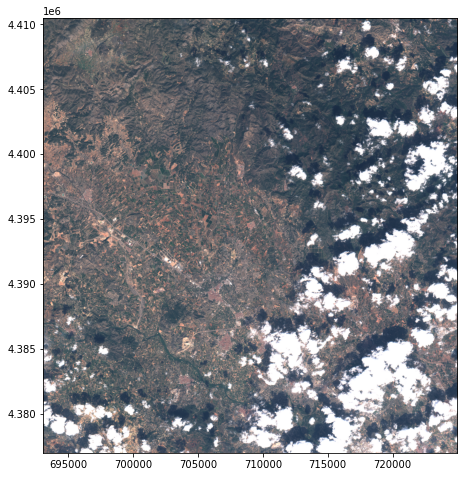

In [11]:
%%time
import numpy as np
from georeader import read
from georeader import mosaic
from georeader import window_utils
import rasterio.plot as rstplt
import matplotlib.pyplot as plt

for day, products_gpd_day in products_gpd.groupby("solarday"):
    idx_pols_selected = select_polygons_overlap(products_gpd_day.geometry, polygon_read)
    
    products_read = products_gpd_day.iloc[idx_pols_selected]["title"]
    print(f"Selected {products_read.shape[0]} products for day {day}")
    s2objs = []
    for product in products_read:
        s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(product+".SAFE", check_exists=True)
        s2objs.append(S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10, bands=["B04", "B03", "B02"]))
    
    polygon_read_dst_crs = window_utils.polygon_to_crs(polygon_read, crs_polygon=crs_polygon, dst_crs=s2objs[0].crs)
    data_memory = mosaic.spatial_mosaic(s2objs, polygon=polygon_read_dst_crs, dst_crs= s2objs[0].crs)
    print(repr(data_memory),type(data_memory))
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    rstplt.show(np.clip((data_memory.values)/3_000,0,1), transform=data_memory.transform, ax=ax)

In [12]:
import geopandas as gpd

pol_mosaic = data_memory.footprint(crs=crs_polygon)

print(f"Overlap {pol_mosaic.intersection(polygon_read).area / polygon_read.area*100:.2f}%")

footprint_downloaded = gpd.GeoDataFrame({"geometry": [pol_mosaic], 
                                         "title": ["footprint mosaic"], 
                                         "group": ["footprint mosaic"]},
                                        crs=crs_polygon)

products_show_all = pd.concat([products_show, footprint_downloaded])

products_show_all.explore("group",tooltip=["title"])

Overlap 100.00%
